In [1]:
%matplotlib osx
from __future__ import division
import numpy as np
from env import *
from collections import defaultdict
import random
from graphviz import Source
from itertools import count
import matplotlib.pyplot as plt
import tensorflow as tf
import time

In [2]:
def is_accept(s):
    s = np.unravel_index(s, env.shape)
    if s[2] in env.rabin.accept:
        return True
    return False

def is_reject(s):
    s = np.unravel_index(s, env.shape)
    if s[2] in env.rabin.reject:
        return True
    return False

def coord_to_direct(new_state, last_state):
    new_state = np.array(np.unravel_index(new_state, env.shape)[:-1])
    last_state = np.array(np.unravel_index(last_state, env.shape)[:-1])
    diff = new_state - last_state
    if diff[0] == 1 and diff[1] == 0:
        return 2
    elif diff[0] == 0 and diff[1] == 1:
        return 1
    elif diff[0] == -1 and diff[1] == 0:
        return 0
    elif diff[0] == 0 and diff[1] == -1:
        return 3
    elif diff[0] == 0 and diff[1] == 0:
        return 4
    
def get_reward(state):
    if is_accept(state):
        return 10
    elif is_reject(state):
        return -10
    else:
        return 0

def max_pu(state):
    next_q = np.zeros(env.nA)
    for action in range(env.nA):
        next_q[action] = np.sum([P[state][action][next_state]*Utilities[next_state] for next_state in P[state][action].keys()])
    return np.max(next_q)

def argmax_q(state):
    q = np.zeros(env.nA)
    for action in range(env.nA):
        q[action] = np.sum([P[state][action][next_state]*Utilities[next_state] for next_state in P[state][action].keys()])
    return np.argmax(q)

def greedy_action(state):
    action = Opt_Policy[state]
    rand_num = random.random()
    if rand_num <= 0.15:
        return np.random.randint(4)
    return action
    

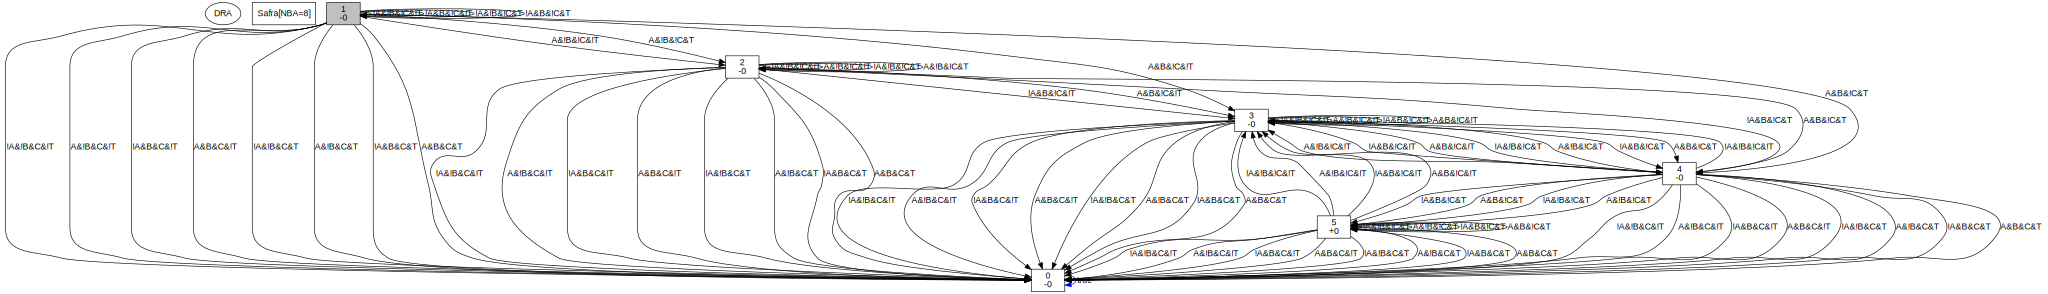

In [3]:
env = CurrentWorld("<>(A && <>B) && []!C")
with open("my.dot", "r") as dotfile:
    text = dotfile.read()
Source(text)

In [4]:
ALPHA = 0.05
ALPHA = 1 - ALPHA
GAMMA = 0.99
SEED = 666
MAX_EPI = 30000
MAX_STEP = 500
random.seed(SEED)
np.random.seed(SEED)
SUMMARY_DIR = "./results/" + time.ctime()[4:16].replace("  ","").replace(" ","_").replace(":","-")

In [5]:
Utilities = {s : 0 for s in range(env.nS)}
State_Frequency = defaultdict(lambda: np.zeros(env.nA))
Outcome = defaultdict(lambda: {a : {} for a in range(env.nA)})
P = defaultdict(lambda: {a : {} for a in range(env.nA)})
Opt_Policy = {s : 0 for s in range(env.nS)}
state_list = []
reward_list = []

# fig, ax = plt.subplots()

episode_reward = tf.Variable(0.)
tf.summary.scalar("Reward", episode_reward)

summary_vars = [episode_reward]
summary_ops = tf.summary.merge_all()
writer = tf.summary.FileWriter(SUMMARY_DIR)

In [6]:
with tf.Session() as sess:
    for epi in range(MAX_EPI):
        state = env.reset()
        last_state = None
        last_action = None
        epi_reward = 0
        done = False
        for step in count():
            if state not in state_list:
                state_list += [state]
                if is_accept(state):
                    Utilities[state] = 10
                elif is_reject(state):
                    Utilities[state] = -10
                else:
                    Utilities[state] = 0

            if last_state is not None:
                State_Frequency[last_state][last_action] += 1
                if state not in Outcome[last_state][last_action].keys():
                    Outcome[last_state][last_action][state] = 1
                else: 
                    Outcome[last_state][last_action][state] += 1
                for s in Outcome.keys():
                    for a in Outcome[s].keys():
                        for t in Outcome[s][a]:
                            if Outcome[s][a][t] != 0:
                                P[s][a][t] = Outcome[s][a][t] / State_Frequency[s][a]
                Utilities[last_state] = ALPHA*Utilities[last_state] + (1 - ALPHA)*(get_reward(state) + 
                                                                                   GAMMA*max_pu(state) )
                Opt_Policy[last_state] = argmax_q(last_state)

            action = greedy_action(state)

            last_state = state
            last_action = action
            state,_,done,_ = env.step(action)

            epi_reward += get_reward(state)
            if done or step >= MAX_STEP:
#                 reward_list += [epi_reward]
#                 print "\rEPI: %i| STEP: %i| REWARD: %i" %(epi, step, epi_reward),
                
                f = open("stats.txt", "ab")
                f.write("| Reward: " + str(int(epi_reward)) 
                        +" | Episode: " + str(epi) 
                        + " | Step: " + str(step) 
                        + "\n")
                f.close()
                
                summary_str = sess.run(summary_ops, feed_dict={
                    summary_vars[0]: epi_reward,                   
                })
                writer.add_summary(summary_str, epi)
                writer.flush()
                
#                 if epi%10 == 0:
#                     ax.clear()
#                     ax.plot(range(epi+1), reward_list)
#                     plt.pause(0.001)
                break



KeyboardInterrupt: 

In [13]:
P

defaultdict(<function __main__.<lambda>>,
            {1: {0: {1: 0.77976190476190477,
               7: 0.12202380952380952,
               31: 0.098214285714285712},
              1: {1: 0.29089443996776793,
               7: 0.60757453666398065,
               31: 0.10153102336825141},
              2: {1: 0.29977916820022082,
               7: 0.10121457489878542,
               31: 0.59900625690099374},
              3: {1: 0.80000000000000004,
               7: 0.095726495726495733,
               31: 0.10427350427350428},
              4: {1: 0.59999999999999998,
               7: 0.29999999999999999,
               31: 0.10000000000000001}},
             7: {0: {1: 0.11059190031152648,
               7: 0.69626168224299068,
               13: 0.070093457943925228,
               37: 0.12305295950155763},
              1: {1: 0.095279720279720273,
               7: 0.21066433566433568,
               13: 0.58304195804195802,
               37: 0.11101398601398602},
             